In [1]:
import dgl
from dgl.data import FraudDataset

dataset = FraudDataset("yelp")
g = dataset[0]
print(g.etypes)
print(g.ntypes)
print(g.ndata)
print(g.ndata.keys())
print()
print(g.ndata["feature"])


Done loading data from cached files.
['net_rsr', 'net_rtr', 'net_rur']
['review']
{'test_mask': tensor([0, 0, 0,  ..., 1, 0, 0], dtype=torch.uint8), 'val_mask': tensor([1, 0, 0,  ..., 0, 0, 0], dtype=torch.uint8), 'train_mask': tensor([0, 1, 1,  ..., 0, 1, 1], dtype=torch.uint8), 'label': tensor([0, 0, 0,  ..., 0, 0, 0]), 'feature': tensor([[0.0224, 0.0705, 0.4287,  ..., 0.5920, 0.1393, 0.4975],
        [0.0249, 1.0000, 1.0000,  ..., 0.5920, 0.1393, 0.4975],
        [0.0062, 0.0705, 0.4287,  ..., 0.5920, 0.1393, 0.4975],
        ...,
        [0.0091, 0.3500, 0.4287,  ..., 0.4826, 0.8010, 0.1642],
        [0.0062, 0.0705, 1.0000,  ..., 0.4428, 0.4478, 0.5871],
        [0.0032, 0.3500, 0.4287,  ..., 0.4428, 0.4478, 0.5871]])}
dict_keys(['test_mask', 'val_mask', 'train_mask', 'label', 'feature'])

tensor([[0.0224, 0.0705, 0.4287,  ..., 0.5920, 0.1393, 0.4975],
        [0.0249, 1.0000, 1.0000,  ..., 0.5920, 0.1393, 0.4975],
        [0.0062, 0.0705, 0.4287,  ..., 0.5920, 0.1393, 0.4975],
  

In [2]:
mask = g.ndata["train_mask"].to(bool)
l = {0: 0, 1: 0}

for x in g.ndata["label"][mask].numpy():
    l[x] += 1
print(l, l[0] / (mask.sum()))

mask = g.ndata["val_mask"].to(bool)
l = {0: 0, 1: 0}

for x in g.ndata["label"][mask].numpy():
    l[x] += 1
print(l, l[0] / (mask.sum()))

mask = g.ndata["test_mask"].to(bool)
l = {0: 0, 1: 0}

for x in g.ndata["label"][mask].numpy():
    l[x] += 1
print(l, l[0] / (mask.sum()))


{0: 27441, 1: 4726} tensor(0.8531)
{0: 3944, 1: 651} tensor(0.8583)
{0: 7892, 1: 1300} tensor(0.8586)


In [3]:
import torch
from torch.nn import functional as F
import pytorch_lightning as pl
import dgl.nn.pytorch as gnn
from torchmetrics import F1Score


class GCN(pl.LightningModule):
    # class GCN(nn.Module):
    def __init__(self, g, in_feats, h_feats, num_classes, rel_names, batch_size=1):
        super().__init__()
        # len(output_nodes) = batch_size

        self.labels = g.ndata["label"]
        self.train_mask = g.ndata["train_mask"].to(bool)
        self.val_mask = g.ndata["val_mask"].to(bool)
        self.test_mask = g.ndata["test_mask"].to(bool)

        if False:
            self.f1 = F1Score("binary").to("cuda")
        else:
            self.f1 = F1Score("binary")

        self.conv0 = gnn.HeteroGraphConv(
            {rel: gnn.SAGEConv(in_feats, h_feats, "mean") for rel in rel_names}
        )
        self.conv1 = gnn.HeteroGraphConv(
            {rel: gnn.SAGEConv(h_feats, num_classes, "mean") for rel in rel_names}
        )
        # self.conv0 = gnn.HeteroGraphConv(
        #     {
        #         "net_rsr": gnn.GraphConv(in_feats, h_feats),
        #         "net_rtr": gnn.GraphConv(in_feats, h_feats),
        #         "net_rur": gnn.GraphConv(in_feats, h_feats),
        #     },
        #     aggregate="sum",
        # )
        # self.conv1 = gnn.HeteroGraphConv(
        #     {
        #         "net_rsr": gnn.GraphConv(h_feats, num_classes),
        #         "net_rtr": gnn.GraphConv(h_feats, num_classes),
        #         "net_rur": gnn.GraphConv(h_feats, num_classes),
        #     },
        #     aggregate="sum",
        # )

    def forward(self, g, in_feat):
        h = self.conv0(g, in_feat)
        h = F.relu(h["review"])
        h = self.conv1(g, {"review": h})
        return h

    def training_step(self, batch, batch_idx):
        # mini batch training -- https://docs.dgl.ai/en/latest/guide/minibatch-node.html#guide-minibatch-node-classification-sampler
        # Forward
        input_nodes, output_nodes, blocks = batch

        # fwd pass
        h = blocks[0].ndata["feature"]
        h = self.conv0(blocks[0], h)
        h = F.relu(h["review"])
        logits = self.conv1(blocks[1], {"review": h})["review"]

        # Compute prediction
        pred = logits.argmax(1).to(torch.int8)

        # Compute loss
        loss = F.cross_entropy(
            logits,
            self.labels[output_nodes],
        )

        # Compute accuracy on training/validation/test
        train_acc = (pred == self.labels[output_nodes]).float().mean()

        self.log("loss", loss, prog_bar=True, on_epoch=True, batch_size=len(output_nodes))
        self.log(
            "acc", train_acc, prog_bar=True, on_epoch=True, batch_size=len(output_nodes)
        )
        return {"loss": loss, "acc": train_acc}

    def validation_step(self, batch, batch_idx):
        # Forward
        input_nodes, output_nodes, blocks = batch

        # fwd pass
        h = blocks[0].ndata["feature"]
        h = self.conv0(blocks[0], h)
        h = F.relu(h["review"])
        logits = self.conv1(blocks[1], {"review": h})["review"]

        # Compute prediction
        pred = logits.argmax(1).to(torch.int8)

        # Compute loss
        loss = F.cross_entropy(
            logits,
            self.labels[output_nodes],
        )

        # Compute accuracy on training/validation/test
        val_acc = (pred == self.labels[output_nodes]).float().mean()
        f1 = self.f1(pred, self.labels[output_nodes]).item()

        self.log(
            "val_loss", loss, prog_bar=True, on_epoch=True, batch_size=len(output_nodes)
        )
        self.log(
            "val_acc",
            val_acc,
            prog_bar=True,
            on_epoch=True,
            batch_size=len(output_nodes),
        )
        self.log("val_f1", f1, prog_bar=True, on_epoch=True, batch_size=len(output_nodes))
        return {"val_loss": loss, "val_acc": val_acc, "val_f1": f1}

    def test_step(self, batch, batch_idx):
        # Forward
        input_nodes, output_nodes, blocks = batch

        # fwd pass
        h = blocks[0].ndata["feature"]
        h = self.conv0(blocks[0], h)
        h = F.relu(h["review"])
        logits = self.conv1(blocks[1], {"review": h})["review"]

        # Compute prediction
        pred = logits.argmax(1).to(torch.int8)

        # Compute loss
        loss = F.cross_entropy(
            logits,
            self.labels[output_nodes],
        )

        # Compute accuracy on training/validation/test
        test_acc = (pred == self.labels[output_nodes]).float().mean()
        f1 = self.f1(pred, self.labels[output_nodes]).item()

        self.log(
            "test_loss", loss, prog_bar=True, on_epoch=True, batch_size=len(output_nodes)
        )
        self.log(
            "test_acc",
            test_acc,
            prog_bar=True,
            on_epoch=True,
            batch_size=len(output_nodes),
        )
        self.log("f1", f1, prog_bar=True, on_epoch=True, batch_size=len(output_nodes))
        return {"test_loss": loss, "test_acc": test_acc, "f1": f1}

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.01)


In [4]:
# from torch.utils.data import DataLoader
from dgl.dataloading import DataLoader

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
batch_size = len(g.ndata["train_mask"])
train_idx = torch.tensor([i for i, x in enumerate(g.ndata["train_mask"]) if x > 0]).to(
    device
)
val_idx = torch.tensor([i for i, x in enumerate(g.ndata["val_mask"]) if x > 0]).to(
    device
)
test_idx = torch.tensor([i for i, x in enumerate(g.ndata["test_mask"]) if x > 0]).to(
    device
)

g = g.to(device)
sampler = dgl.dataloading.MultiLayerFullNeighborSampler(2)
dataloader = DataLoader(g, train_idx, sampler, batch_size=batch_size)
val_set = DataLoader(g, val_idx, sampler, batch_size=len(val_idx))
test_set = DataLoader(g, test_idx, sampler, batch_size=len(test_idx))


RuntimeError: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero.

In [ ]:
from pytorch_lightning.loggers import MLFlowLogger

mlf_logger = MLFlowLogger()
model = GCN(g, g.ndata["feature"].shape[1], 16, dataset.num_classes, g.etypes)
trainer = pl.Trainer(
    max_epochs=5_000,
    # accelerator="cpu",
    log_every_n_steps=1,
    logger=mlf_logger
)
trainer.fit(model, dataloader,val_dataloaders=val_set)
trainer.test(model, dataloaders=test_set)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type            | Params
------------------------------------------
0 | f1    | BinaryF1Score   | 0     
1 | conv0 | HeteroGraphConv | 3.1 K 
2 | conv1 | HeteroGraphConv | 198   
------------------------------------------
3.3 K     Trainable params
0         Non-trainable params
3.3 K     Total params
0.013     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/rross/.venv/ml/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/rross/.venv/ml/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:120: UserWarning: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.
  rank_zero_warn(


/home/rross/.venv/ml/lib/python3.10/site-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (
/home/rross/.venv/ml/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 4999: 100%|██████████| 1/1 [00:00<00:00, 14.03it/s, v_num=f933, loss_step=0.230, acc_step=0.906, val_loss=0.240, val_acc=0.900, val_f1=0.592, loss_epoch=0.230, acc_epoch=0.906]

`Trainer.fit` stopped: `max_epochs=5000` reached.


Epoch 4999: 100%|██████████| 1/1 [00:00<00:00, 13.38it/s, v_num=f933, loss_step=0.230, acc_step=0.906, val_loss=0.240, val_acc=0.900, val_f1=0.592, loss_epoch=0.230, acc_epoch=0.906]


You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/rross/.venv/ml/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.15it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
           f1               0.6117441058158875
        test_acc            0.9036118388175964
        test_loss           0.23913544416427612
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.23913544416427612,
  'test_acc': 0.9036118388175964,
  'f1': 0.6117441058158875}]

/home/rross/.venv/ml/lib/python3.10/site-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


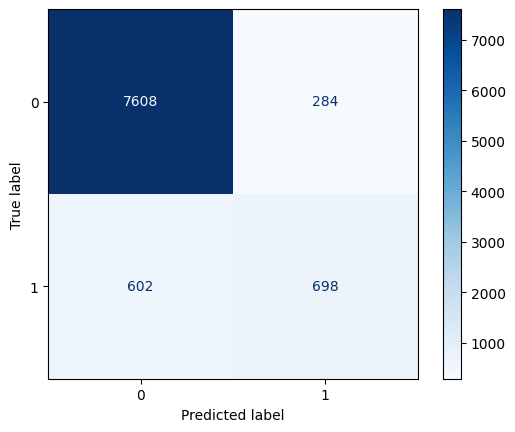

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

features = {"review": g.ndata["feature"].to(device)}
model = model.to(device)
logits = model(g.to(device), features)["review"]
test_mask = g.ndata["test_mask"].cpu().to(bool)
labels = g.ndata["label"][test_mask].cpu()
pred = logits.argmax(1)[test_mask].cpu()

cm = confusion_matrix(labels, pred)
cm = ConfusionMatrixDisplay(cm)
cm.plot(cmap="Blues")

